In [2]:
%matplotlib notebook
#%matplotlib inline
import serial, time
import numpy as np
from matplotlib import pyplot as plt
#import time
import ipywidgets as widgets
#check the Arduino IDE to see what serial port it's attached to
PORT = '/dev/ttyUSB0'
BAUDRATE = 57600

## Lab calorimetry
<div class="alert alert-block alert-info">
<b>Intro:</b> Two bodies at different temperatures, when put in thermal contact, exchange <b>Heat</b>. 
</div>


$Q_1 = C_1\, m_1\, (T1_f  - T1_i)$,     $ Q_2 = C_2\, m_2\, (T_f  - T2_i)$.
<div class="alert alert-block alert-warning">
⚠️ Whithin a Isolated system: 
</div> $Q_2 = -Q_1$  

$C\, m\, (T_1  - T_f) = C_2\, m_2\, (T_f  - T_2) \equiv C\, m\, T_1 + C_2\, m_2\, T_2 = C_2\, m_2\, T_f + C\, m\,  T_f \implies T_f  = \frac{C\, m\, T_1 + C_2\, m_2\, T_2}{
C m +C_2  m_2 }$

$C_1 = C_2  \frac{m_2 + m_{equiv}}{m_1} \frac{T_f  - T_2}{T_1  - T_f}$   
($C_2 = 4.186~kJkg^{-1}\,ºC^{-1}$)

$C_H\, m_{Hboil}\, (T_{boil} - T_f) = C_x\, m_x\, (T_f  - T_I) + C_H\, m_{HI}\, (T_f  - T_I) $  
$C_H\, m_{Hboil}\, (T_{boil} - T_f) = (C_x\, m_x\ +  C_H\, m_{HI} ) (T_f  - T_I))$  
$C_H\, m_{Hboil} \frac{T_{boil} - T_f}{T_f  - T_I} = C_x\, m_x\  + C_H\, m_{HI} $  
$ C_x\, m_x = C_H\, m_{Hboil} \frac{T_{boil} - T_f}{T_f  - T_I} - C_H\, m_{HI} = C_H \big ( m_{Hboil} \frac{T_{boil} - T_f}{T_f  - T_I} - m_{HI}\big) $

In [3]:
cxmx= CH * (mH2b * (Tboi - Tf)/ (Tf-TI) - mHi)

NameError: name 'CH' is not defined

In [8]:
# ser.write(b'*IDN?\n')
#    ser.write(b'MEAS:SCAL:VOLT:DC1?\n')
def get_temp(serl, probe):
    p_str = f'{probe:d}'
    command = b'MEAS:SCAL:TEMP:DS' + p_str.encode('utf-8') + b'?\n'
    serl.write(command)
    line = serl.readline()
    return float(line)
with serial.Serial(PORT, BAUDRATE, timeout=1) as ser:
    ser.write(b'MEAS:SCAL:TEMP:DS0?\n')
    line = ser.readline()   # read a '\n' terminated line
    print(line)

b'25.5000\r\n'


In [9]:
#@title Data Acquisition
# duration = 60 # @param {type:"slider", min:1, max:300, step:1}
mCal = widgets.BoundedFloatText(
    value=300.0,
    min=200,
    max=400.0,
    step=0.1,
    description='Calorimeter Mass(g):',
    disabled=False
)
display(mCal)
mCalCu = widgets.BoundedFloatText(
    value=600.0,
    min=550,
    max=800.0,
    step=0.1,
    description='Calori + Sample Mass(g):',
    disabled=False
)
display(mCalCu)
mCalCuH2O = widgets.BoundedFloatText(
    value=700.0,
    min=700,
    max=900.0,
    step=0.1,
    description='(Calori + Sample + H2O) Mass(g):',
    disabled=False
)
display(mCalCuH2O)

dT = widgets.IntSlider(min=10, max=300, value=60, step=2, description="Acquisition Time (s)")
display(dT)

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


In [10]:
mCu = mCalCu.value - mCal.value
mH2O_0 = mCalCuH2O.value - mCalCu.value +24
print(f'Sample Mass: {mCu:.2f} g, MH2O: {mH2O_0:.2f} g')
with serial.Serial(PORT, 57600, timeout=1) as ser:
    ser.reset_input_buffer()
    Tred = get_temp(ser, 0)
    Tblue = get_temp(ser, 1)
    print(f'Tred: {Tred:.2f}, Tblue: {Tblue:.2f}')


Sample Mass: 300.00 g, MH2O: 124.00 g
Tred: 25.50, Tblue: 26.75


<IPython.core.display.Javascript object>


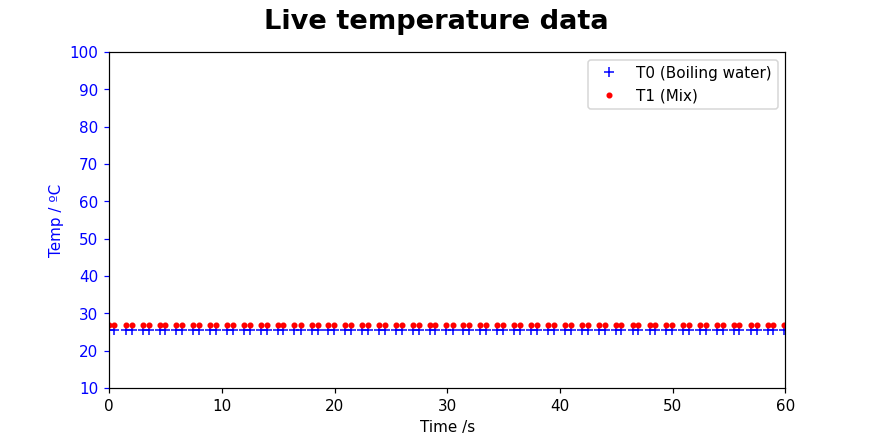

T0final: 25.56, T1final: 26.81


In [11]:
duration = dT.value
#view_time = 4 # seconds of data to view at once
plt.rcParams['figure.figsize'] = [8, 4]
fig, ax1 = plt.subplots()

fig.suptitle('Live temperature data', fontsize='18', fontweight='bold')
ax1.set_xlabel('Time /s')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Temp / ºC', color='b')
ax1.tick_params('y', colors='b')

xrange = [0,duration]
yrange = [10.0, 100.0]
ax1.set_xlim(xrange)
ax1.set_ylim(yrange)

# interactive mode will be on
# figures will automatically be shown
#plt.ion()
#fig.show()

#timeStart = float(data[0]); # in milli sec

run = True
cycles = 0
#collect the data and plot a moving frame
with serial.Serial(PORT, 57600, timeout=1) as ser:
    ser.reset_input_buffer()
    time_initial = time.time()
    xdata =   [0.0]
    T0initial = get_temp(ser, 0)
    T1initial = get_temp(ser, 1)    
    y0data =   [T0initial] 
    y1data =   [T1initial] 
    ln0, = ax1.plot(xdata, y0data, '+', color='blue', label='T0 (Boiling water)')
    ln1, = ax1.plot(xdata, y1data, '.', color='red', label='T1 (Mix)')
    ax1.legend(loc='best')
    
    while run:
        cycles +=1
        # sometimes the incoming data is garbage, so just 'try' to do this
        try:
            # xdata.append((float(data[0]) - timeStart )/1000.0 )
            xdata.append(time.time()- time_initial)
            y0data.append(get_temp(ser, 0)) 
            ln0.set_data(xdata, y0data)
            y1data.append(get_temp(ser, 1)) 
            ln1.set_data(xdata, y1data)
            #ax2.plot(xdata, y2data, 'r.')
            # when time's up, kill the collect+plot loop
            if xdata[-1] > duration: run=False
        # if the try statement throws an error, just do nothing
        except: 
            pass
        # update the plot
        fig.canvas.draw()
        fig.canvas.flush_events()

T0final = y0data[-1] 
T1final = y1data[-1]
print(f'T0final: {T0final:.2f}, T1final: {T1final:.2f}')
fname = 'data_' + time.strftime("%Y%m%d-%H%M%S") + '.txt'
save_array=np.array([xdata, y0data , y1data])
np.savetxt(fname, save_array.transpose())
#print('After  {0:d} cycles, average of Period is {1:.5f} +- {2:.5f}(s).'.format(cycles, \
#                            np.average(y1data), np.std(y1data)))


In [20]:
mFinal= widgets.BoundedFloatText(
    value=800.0,
    min=800,
    max=1100.0,
    step=0.1,
    description='Final Mass(g):',
    disabled=False
)
display(mFinal)


In [25]:
mH2O_1 = mFinal.value - mCalCuH2O.value
print(f'Boiling H2O: {mH2O_1:.2f} g')

Boiling H2O: 70.10 g


In [30]:
TmixI = y0data[0]
TmixF = y0data[-1]
Tboiling = max(y1data)
print(f'TmixI: {TmixI:.2f} ºC,   Boiling H2O: {Tboiling:.2f} ºC, TmixF: {TmixF:.2f} ºC')

TmixI: 25.00 ºC,   Boiling H2O: 95.44 ºC, TmixF: 44.56 ºC


In [40]:
C_H20 = 4.186 # J/g/ºC'
cxmx = C_H20 * (mH2O_1 * (Tboiling - TmixF)/ (TmixF-TmixI) - mH2O_0)
Cx = cxmx / mCu
print(f'Cx: {Cx:.3f} J/Kg/ºC')
#C_Sample = C_H20 * (mCu + mH2O_0 + 0.024) 
#mH2O_0 = mCalCuH2O.value - mCalCu.value)

Cx: 0.622 J/Kg/ºC


In [ ]:
print(f'T0final: {T0final:.2f}, T1final: {T1final:.2f}')

In [ ]:
dat=np.loadtxt('data_20180515-185726.txt')
time=dat[:,0]
period=dat[:,1]
#period

In [ ]:
# plot all of the data you collected
fig2, ax1 = plt.subplots()
#fig2 = plt.figure()
# http://matplotlib.org/users/text_props.html
fig2.suptitle('complete data trace', fontsize='18', fontweight='bold')
plt.xlabel('time, seconds', fontsize='14', fontstyle='italic')
plt.ylabel('potential, volts', fontsize='14', fontstyle='italic')
#plt.axes().grid(True)
plt.plot(time,period,marker='o',markersize=4,linestyle='none',markerfacecolor='red')
yrange = [2.655,2.665]
plt.grid()
plt.ylim(yrange)
fig2.show()
